In [1]:
import nltk
nltk.download('gutenberg')
nltk.download('punkt_tab')
nltk.download('stopwords')
import re
from nltk.corpus import gutenberg, stopwords
from gensim.models import Doc2Vec, Word2Vec
from gensim.models.doc2vec import TaggedDocument

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load dataset

In [2]:
corpus = list(gutenberg.sents('shakespeare-hamlet.txt'))

In [3]:
print('Type of corpus: ', type(corpus))
print('Length of corpus: ', len(corpus))

Type of corpus:  <class 'list'>
Length of corpus:  3106


In [4]:
for sentence in corpus[0:3]:
    print(sentence)

['[', 'The', 'Tragedie', 'of', 'Hamlet', 'by', 'William', 'Shakespeare', '1599', ']']
['Actus', 'Primus', '.']
['Scoena', 'Prima', '.']


# Preprocess the data
We do a very simple preprocessing here by:
- Removing the strings that are not a word
- Removing the stop words
- Keeping a lowercase version of the strings.

In [5]:
for i in range(len(corpus)):
    stop_words = set(stopwords.words('english'))
    corpus[i] = [word.lower() for word in corpus[i] if re.match('^[a-zA-Z]+', word) and word not in stop_words]

In [6]:
for sentence in corpus[0:3]:
    print(sentence)

['the', 'tragedie', 'hamlet', 'william', 'shakespeare']
['actus', 'primus']
['scoena', 'prima']


# Word2Vec
We use here [the Word2Vec](https://en.wikipedia.org/wiki/Word2vec) model [from the gensim api](https://radimrehurek.com/gensim/models/word2vec.html)

### Training the model
Create a word2vec model from the hamlet corpus\
The parameters we use here are:
- sentences: training data, our corpus
- vector_size: dimension of embedding space
- window: number of words accounted for each context (if the window size is 3, 3 word in the left neighorhood and 3 word in the right neighborhood are considered)
- min_count: minimum count of words to be included in the vocabulary
- workers: number of worker threads to train

In [7]:
word2vec_model = Word2Vec(sentences = corpus, vector_size = 5, window = 3, min_count = 1)
word2vec_model.save('models/word2vec_model')

### Visualizing the model

In [ ]:
print("embedding of the word king:")
print(word2vec_model.wv['king'])
print("most similar words to hamlet:")
print(word2vec_model.wv.most_similar("hamlet"))

[('cause', 0.9958978891372681),
 ('congregation', 0.9944615364074707),
 ('giue', 0.99434894323349),
 ('pioner', 0.9902486801147461),
 ('weeping', 0.9896981120109558),
 ('marke', 0.9843466877937317),
 ('battery', 0.9840864539146423),
 ('fro', 0.9824756383895874),
 ('witnesse', 0.9820194840431213),
 ('pickhaxe', 0.9818595051765442)]

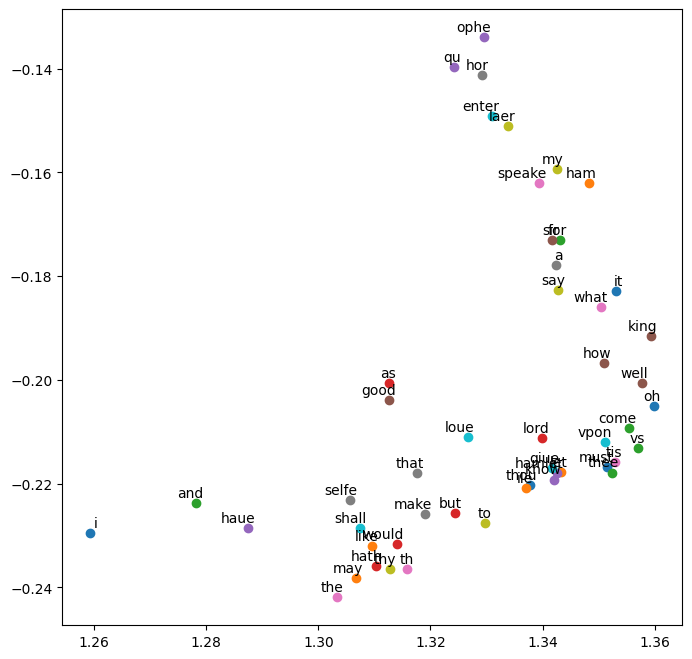

In [10]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_embeddings(embeddings, words):
    tsne = TSNE(n_components=2, random_state=0, perplexity=len(words)-1)
    embedding_vectors = np.array([embeddings[word] for word in words])
    two_d_embeddings = tsne.fit_transform(embedding_vectors)

    plt.figure(figsize=(8, 8))
    for i, word in enumerate(words):
        x, y = two_d_embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(word, (x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")
    plt.show()

word2vec_words = word2vec_model.wv.index_to_key
visualize_embeddings(word2vec_model.wv, word2vec_words[:50]) # We take a subset of the words for readability

# Doc2Vec
We use an extension of Word2Vec, called Doc2Vec [from the gensim api](https://radimrehurek.com/gensim/models/doc2vec.html#gensim.models.doc2vec.Doc2Vec)

### Training the model

In [11]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)
doc2vec_model.save('models/doc2vec_model')

### Visualizing the model

In [ ]:
print("embedding of the word queen:")
print(doc2vec_model.wv["queen"])
print("most similar words to hamlet:")
print(doc2vec_model.wv.most_similar("hamlet"))

[('that', 0.9970059990882874),
 ('i', 0.9968682527542114),
 ('the', 0.9967049956321716),
 ('and', 0.9965363144874573),
 ('th', 0.9965142607688904),
 ('make', 0.9964504241943359),
 ('hath', 0.9964231252670288),
 ('selfe', 0.9962102174758911),
 ('with', 0.9961467385292053),
 ('to', 0.9961068034172058)]

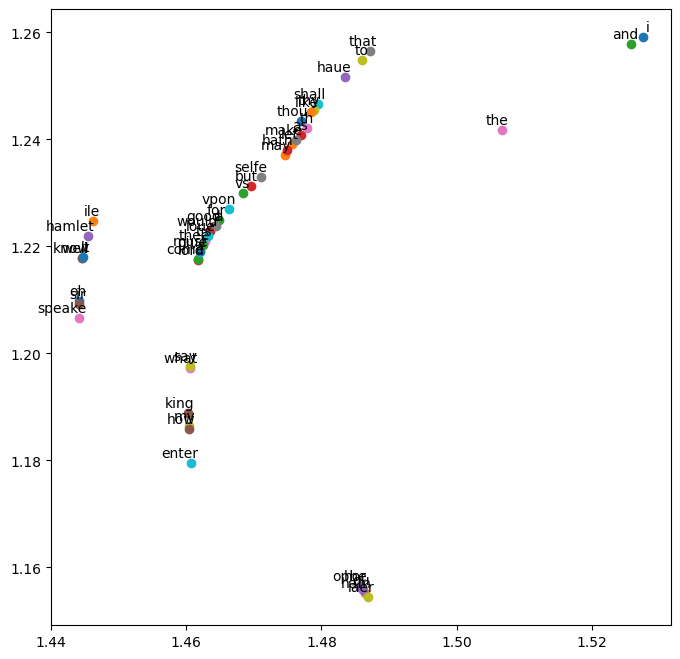

In [13]:
doc2vec_words = doc2vec_model.wv.index_to_key
visualize_embeddings(doc2vec_model.wv, doc2vec_words[:50])

# Implement your own

If you feel like it, you can try to implement your own way word embedding and compare it with the two above!

# [Bonus] Task-aware embedding



In [16]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from torch import Tensor

def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

In [17]:
tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-Embedding-0.6B', padding_side='left')
model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-0.6B')

documents = [
    "As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day. But, as you can see from this chart, you'll need to increase that if you're expecting or training for a marathon. Check out the chart below to see how much protein you should be eating each day.",
    "Definition of summit for English Language Learners. : 1  the highest point of a mountain : the top of a mountain. : 2  the highest level. : 3  a meeting or series of meetings between the leaders of two or more governments."
]

max_length = 4096
batch_dict = tokenizer(documents, max_length=max_length - 1, return_attention_mask=False, padding=False, truncation=True)
batch_dict['input_ids'] = [input_ids + [tokenizer.eos_token_id] for input_ids in batch_dict['input_ids']]
batch_dict = tokenizer.pad(batch_dict, padding=True, return_attention_mask=True, return_tensors='pt')
outputs = model(**batch_dict)
embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])



tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [21]:
task = 'Given a web search query, retrieve relevant passages that answer the query'
queries = [
    get_detailed_instruct(task, 'how much protein should a female eat'),
    get_detailed_instruct(task, 'summit define')
]

batch_dict = tokenizer(queries, max_length=max_length - 1, return_attention_mask=False, padding=False, truncation=True)
# append eos_token_id to every input_ids
batch_dict['input_ids'] = [input_ids + [tokenizer.eos_token_id] for input_ids in batch_dict['input_ids']]
batch_dict = tokenizer.pad(batch_dict, padding=True, return_attention_mask=True, return_tensors='pt')

outputs = model(**batch_dict)
embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
print(embeddings)

tensor([[-3.7856, -5.5080, -1.2269,  ..., -3.4153, -0.9376,  1.3144],
        [-0.3469, -6.0758, -1.5423,  ..., -0.7458, -1.4792, -1.7878]],
       grad_fn=<SelectBackward0>)
